<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_classificationmodelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd

In [3]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

In [4]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data_1[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

In [5]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

blue_collar     21017
white_collar    16217
not_working      3606
unknown           330
Name: job_new, dtype: int64

In [6]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

summer    18660
spring    16942
fall       5386
winter      182
Name: season, dtype: int64

In [7]:
data_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new',
       'season'],
      dtype='object')

### Data Transformation - V1 (Agreed on Team Discussion)

In [8]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [9]:
df_tran_1.shape
#this is because we removed illiterate

(41170, 21)

In [10]:
df_tran_1 = df_tran_1.drop(['duration'], axis=1)
df_tran_1.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'edu_new', 'job_new', 'season'],
      dtype='object')

### One Hot Encoding For Categorical Features

In [11]:
y = df_tran_1['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36534
1     4636
Name: y, dtype: int64

In [12]:
x = df_tran_1.drop('y', axis=1)

In [13]:
df_raw = pd.get_dummies(x)
df_raw.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [14]:
#drop the unknow columns as they are correlated to other categories

df_raw = df_raw.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown', 'edu_new_unknown', 'job_new_unknown'], axis=1)
df_raw.shape

(41170, 38)

### Train-Test Split & Data Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_raw = scaler.fit_transform(df_raw)

In [16]:
df_raw

array([[0.48148148, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.49382716, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.24691358, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.48148148, 0.01818182, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.7037037 , 0.03636364, 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train,x_test,y_train,y_test = train_test_split(df_raw, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train.shape,
      x_test.shape,
      y_train.shape,
      y_test.shape)

(32936, 38) (8234, 38) (32936,) (8234,)


### Balancing the data using SMOTE

https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3


In [18]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 12.1 MB/s 
     |████████████████████████████████| 199 kB 52.1 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [19]:
import imblearn

smote = SMOTE()

x_s, y_s = smote.fit_resample(x_train, y_train)

print('Original dataset shape', len(x_train))
print('Resampled dataset shape', len(x_s))

Original dataset shape 32936
Resampled dataset shape 58454


In [20]:
y_s.value_counts()

0    29227
1    29227
Name: y, dtype: int64

### Classification with Neural Network

In [21]:
model = Sequential()
model.add(Dense(units = 32, kernel_initializer = 'he_uniform',activation='relu',input_dim = x_s.shape[1]))
model.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu'))
model.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

may need to revisit the kernel initialization and tweaking the model
here is the reference:https://www.kaggle.com/code/trolukovich/glorot-vs-he-weight-initialization-experiment/notebook

In [22]:
model.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1248      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_history = model.fit(x_s, y_s,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 20s 5ms/step - loss: 0.4655 - accuracy: 0.7968 - val_loss: 1.0482 - val_accuracy: 0.4146
Epoch 2/100
3917/3917 [==============================] - 14s 4ms/step - loss: 0.4458 - accuracy: 0.8105 - val_loss: 1.0609 - val_accuracy: 0.4314
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4428 - accuracy: 0.8111 - val_loss: 1.0568 - val_accuracy: 0.4142
Epoch 4/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4408 - accuracy: 0.8130 - val_loss: 1.1204 - val_accuracy: 0.4021
Epoch 5/100
3917/3917 [==============================] - 10s 2ms/step - loss: 0.4389 - accuracy: 0.8122 - val_loss: 1.1403 - val_accuracy: 0.3750
Epoch 6/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4374 - accuracy: 0.8133 - val_loss: 0.9660 - val_accuracy: 0.4674
Epoch 7/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4359 - accuracy: 0.8146 - val_loss: 1.0265 - val

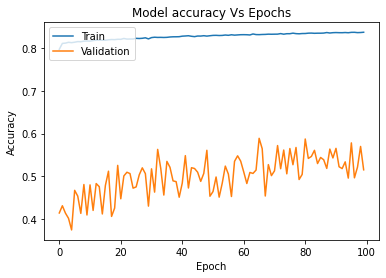

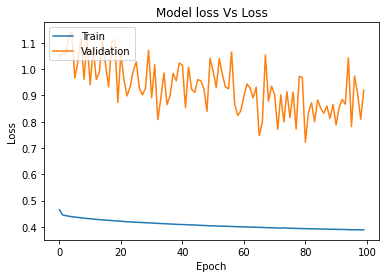

In [24]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
df_raw_2 = pd.get_dummies(x)

df_raw_2 = df_raw_2.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 
                        'loan_unknown', 'edu_new_unknown', 'job_new_unknown',
                        'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
                        'day_of_week_tue', 'day_of_week_wed', 'season_winter'], axis=1)
df_raw_2.shape

(41170, 32)

In [32]:
scaler = MinMaxScaler()
x_2 = scaler.fit_transform(df_raw_2)

In [33]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(x_2, y, test_size = 0.2, random_state=42)
#take out stratify approach
print(x_train2.shape,
      x_test2.shape,
      y_train2.shape,
      y_test2.shape)

(32936, 32) (8234, 32) (32936,) (8234,)


In [34]:
smote = SMOTE()

x_s2, y_s2 = smote.fit_resample(x_train2, y_train2)

print('Original dataset shape', len(x_train2))
print('Resampled dataset shape', len(x_s2))

Original dataset shape 32936
Resampled dataset shape 58454


In [35]:
model2 = Sequential()
model2.add(Dense(units = 32, activation='relu',input_dim = x_s2.shape[1]))
model2.add(Dense(units = 8 ,activation='relu'))
model2.add(Dense(units = 1, activation = 'sigmoid'))

In [37]:
model2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,329
Trainable params: 1,329
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_history = model2.fit(x_s2, y_s2,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 11s 3ms/step - loss: 0.4553 - accuracy: 0.8039 - val_loss: 1.0788 - val_accuracy: 0.4351
Epoch 2/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4455 - accuracy: 0.8123 - val_loss: 1.0900 - val_accuracy: 0.4706
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4442 - accuracy: 0.8136 - val_loss: 1.0664 - val_accuracy: 0.4440
Epoch 4/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4431 - accuracy: 0.8146 - val_loss: 0.9814 - val_accuracy: 0.4891
Epoch 5/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4434 - accuracy: 0.8145 - val_loss: 0.9772 - val_accuracy: 0.4958
Epoch 6/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4430 - accuracy: 0.8152 - val_loss: 1.1326 - val_accuracy: 0.4478
Epoch 7/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4425 - accuracy: 0.8149 - val_loss: 1.0255 - val_a

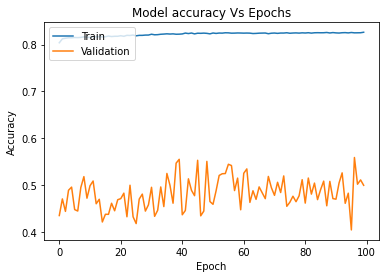

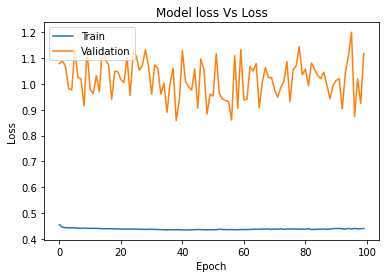

In [40]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [41]:
data_dur = data_1.copy()

In [46]:
df_dur = data_dur[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [47]:
y = df_dur['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36534
1     4636
Name: y, dtype: int64

In [48]:
x = df_dur.drop('y', axis=1)

In [49]:
df_raw_3 = pd.get_dummies(x)
df_raw_3.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [50]:
#drop the unknow columns as they are correlated to other categories

df_raw_3 = df_raw_3.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 
                        'loan_unknown', 'edu_new_unknown', 'job_new_unknown',
                        'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
                        'day_of_week_tue', 'day_of_week_wed', 'season_winter'], axis=1)
df_raw_3.shape

(41170, 33)

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_3 = scaler.fit_transform(df_raw_3)

In [52]:
x_3

array([[0.48148148, 0.05307035, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49382716, 0.03029687, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.24691358, 0.04595364, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48148148, 0.03843026, 0.01818182, ..., 1.        , 0.        ,
        0.        ],
       [0.33333333, 0.08987393, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.7037037 , 0.04859699, 0.03636364, ..., 1.        , 0.        ,
        0.        ]])

In [54]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train3,x_test3,y_train3,y_test3 = train_test_split(x_3, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train3.shape,
      x_test3.shape,
      y_train3.shape,
      y_test3.shape)

(32936, 33) (8234, 33) (32936,) (8234,)


In [55]:
import imblearn

smote = SMOTE()

x_s3, y_s3 = smote.fit_resample(x_train3, y_train3)

print('Original dataset shape', len(x_train3))
print('Resampled dataset shape', len(x_s3))

Original dataset shape 32936
Resampled dataset shape 58454


In [56]:
y_s3.value_counts()

0    29227
1    29227
Name: y, dtype: int64

In [57]:
model3 = Sequential()
model3.add(Dense(units = 32, kernel_initializer = 'he_uniform',activation='relu',input_dim = x_s3.shape[1]))
model3.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu'))
model3.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [58]:
model3.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                1088      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_history = model3.fit(x_s3, y_s3,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 10s 2ms/step - loss: 0.4405 - accuracy: 0.8008 - val_loss: 0.9075 - val_accuracy: 0.4571
Epoch 2/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3598 - accuracy: 0.8285 - val_loss: 0.6827 - val_accuracy: 0.5924
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3084 - accuracy: 0.8588 - val_loss: 0.5271 - val_accuracy: 0.7297
Epoch 4/100
3917/3917 [==============================] - 10s 2ms/step - loss: 0.2905 - accuracy: 0.8705 - val_loss: 0.5001 - val_accuracy: 0.7663
Epoch 5/100
3917/3917 [==============================] - 12s 3ms/step - loss: 0.2830 - accuracy: 0.8744 - val_loss: 0.5311 - val_accuracy: 0.7497
Epoch 6/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.2771 - accuracy: 0.8764 - val_loss: 0.5308 - val_accuracy: 0.7509
Epoch 7/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.2736 - accuracy: 0.8767 - val_loss: 0.4727 - val

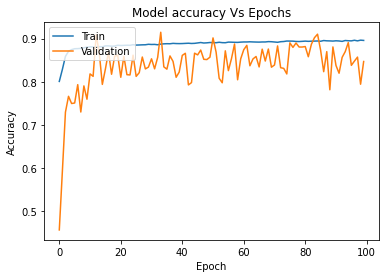

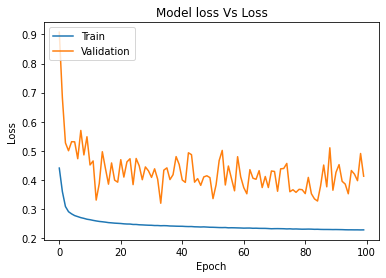

In [60]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Data Transformation - V2 (Shawn's attempt based on FAMDD analysis)
##### if you are focusing on the agreed v1, feel free to skip this part, just want to experiment, may not have too signficant impact

In [ ]:
data_2 = data.copy()

In [ ]:
#findings from FAMD analysis
# there is significant distinguishablity for feature - poutcome / contact / default, so no need to combine any features
# job -> separate student and retired stand alone as they are distinguished from others
# housing, loan are alomost overlapping for all segment, not meaningful to consolidate

In [ ]:
data_2['edu_new'] = data_2['education'].map({'basic.4y': 'pre_colleage', 
                                         'basic.9y': 'pre_colleage',
                                         'basic.6y': 'pre_colleage',
                                         'university.degree' : 'post_colleage',
                                         'professional.course':'post_colleage',
                                         'illiterate': 'illiterate',
                                         'high.school' : 'pre_colleage',
                                         'unknown' :'unknown' })

data_2['edu_new'].value_counts(dropna = False)

pre_colleage     22028
post_colleage    17411
unknown           1731
illiterate          18
Name: edu_new, dtype: int64

In [ ]:
def map_job_2(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed', 'housemaid', 'blue-collar', 'technician', 'services', 'unemployed']:
        cat = 'others'
    elif row['job'] in ['retired']:
        cat = 'retired'
    elif row['job'] in ['student']:
        cat = 'student'
    else:
        cat = 'unknown'
    return cat

data_2['job_new'] = data_2.apply(map_job_2, axis=1)
data_2['job_new'].value_counts(dropna = False)

others     38263
retired     1720
student      875
unknown      330
Name: job_new, dtype: int64

In [ ]:
def map_marri(row):
    if row['job'] in ['divorced', 'married', 'unknown']:
        cat = 'not_single'
    else:
        cat = 'single'
    return cat

data_2['marr_new'] = data_2.apply(map_marri, axis=1)
data_2['marr_new'].value_counts(dropna = False)

single        40858
not_single      330
Name: marr_new, dtype: int64

In [ ]:
def map_month_2(row):
    if row['month'] in ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']:
        cat = 'non_winter'
    else:
        cat = 'winter'
    return cat

data_2['season_new'] = data_2.apply(map_month_2, axis=1)
data_2['season_new'].value_counts(dropna = False)

non_winter    41006
winter          182
Name: season_new, dtype: int64

In [ ]:
df_tran_2 = data_2.drop(['job', 'marital', 'education', 'month'], axis=1)